NAIROBI OZONESONDE DATA AVAILABILITY

Total launches from 1998 to 2024: 1044


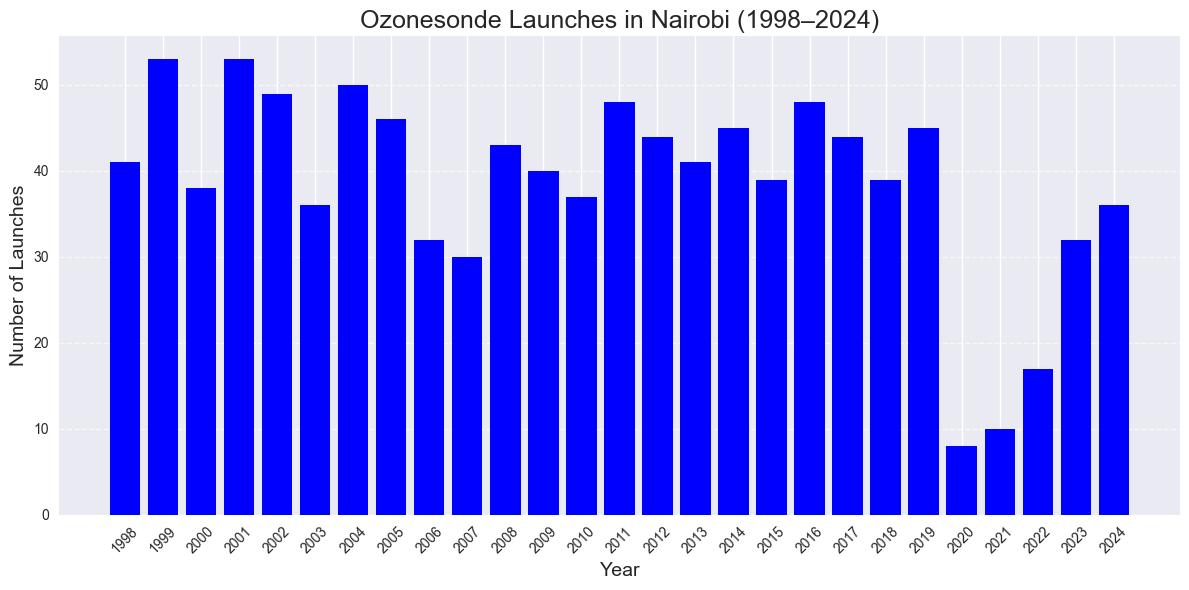

In [2]:
import os
import matplotlib.pyplot as plt

# data Configuration
base_dir = "Ozonesondes"
start_year, end_year = 1998, 2024

years = sorted({
    int(tok)
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
    for tok in d.split("_")
    if tok.isdigit() and start_year <= int(tok) <= end_year
})

# Count launches per year
launch_counts = []
for year in years:
    year_folder = f"shadoz_nairobi_{year}_V06"
    path = os.path.join(base_dir, year_folder)
    try:
        files = [f for f in os.listdir(path)
                 if os.path.isfile(os.path.join(path, f))]
        count = len(files)
    except FileNotFoundError:
        count = 0
    launch_counts.append(count)

# Total count calculation
total_launches = sum(launch_counts)
print(f"Total launches from {start_year} to {end_year}: {total_launches}")

# Plotting 
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(years, launch_counts, color="blue")
ax.set_title("Ozonesonde Launches in Nairobi (1998–2024)", fontsize=18)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Launches", fontsize=14)

ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


OZONE & TEMPERATURE VERTICAL PROFILES FOR 30TH OCT 2024

      GeopAlt   Temp  O3_mPa
0       1.790  25.00  3.4211
1       1.803  23.67  3.4606
2       1.806  23.58  3.4606
3       1.810  23.42  3.4607
4       1.813  23.30  3.4607
...       ...    ...     ...
7076   33.193 -37.98  6.7099
7077   33.193 -37.93  6.7099
7078   33.202 -37.87  6.6709
7079   33.202 -37.80  6.6312
7080   33.212 -37.71  6.6318

[7081 rows x 3 columns]
Extracted 7081 rows and 3 columns


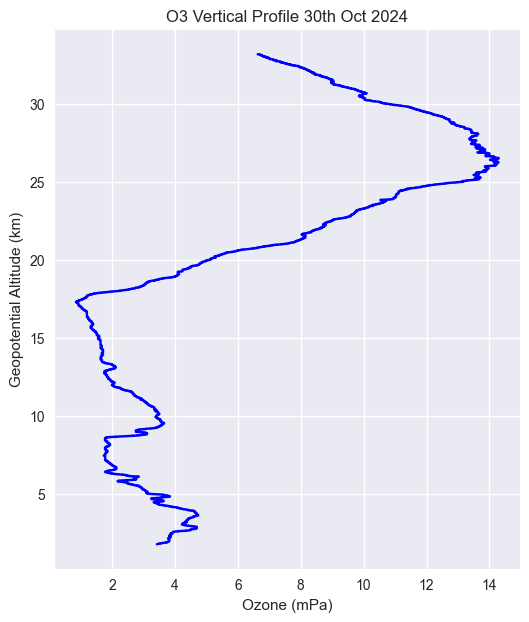

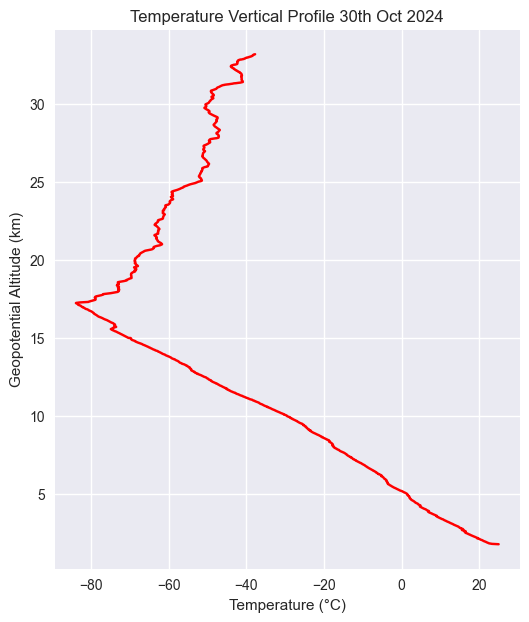

In [3]:
import os
import glob
import pandas as pd

# pick a specific launch
base_dir    = "Ozonesondes"
year_folder = os.path.join(base_dir, "shadoz_nairobi_2024_V06")
pattern     = os.path.join(year_folder, "nairobi_20241030T07_SHADOZV06*")
launch_file = glob.glob(pattern)[0]

# find the header row
header_line_idx = None
with open(launch_file, 'r') as f:
    for idx, line in enumerate(f):
        if line.lstrip().startswith("Time") and "GeopAlt" in line and "O3_mPa" in line:
            header_line_idx = idx
            break
if header_line_idx is None:
    raise ValueError("Could not find header line containing 'Time' and 'GeopAlt'")

# skip everything before the header
skiprows    = list(range(header_line_idx)) + [header_line_idx + 1]

# read all data, selecting only the three target columns ["GeopAlt", "O3_mPa", "Temp"]
ozone = pd.read_csv(
    launch_file,
    sep=r'\s+',
    engine='python',
    skiprows=skiprows,
    header=0,
    usecols=["GeopAlt", "O3_mPa", "Temp"]
)

# inspect full DataFrame
print(ozone)

# confirm you have all rows
print(f"Extracted {ozone.shape[0]} rows and {ozone.shape[1]} columns")

# plotting

import matplotlib.pyplot as plt

# Ozone profile figure
fig_o3, ax_o3 = plt.subplots(figsize=(6, 7))
ax_o3.plot(ozone['O3_mPa'], ozone['GeopAlt'], color='blue')
ax_o3.set_xlabel('Ozone (mPa)')
ax_o3.set_ylabel('Geopotential Altitude (km)')
ax_o3.set_title('O3 Vertical Profile 30th Oct 2024')
ax_o3.grid(True)

# Temperature profile figure
fig_temp, ax_temp = plt.subplots(figsize=(6, 7))
ax_temp.plot(ozone['Temp'], ozone['GeopAlt'], color='red')
ax_temp.set_xlabel('Temperature (°C)')
ax_temp.set_ylabel('Geopotential Altitude (km)')
ax_temp.set_title('Temperature Vertical Profile 30th Oct 2024')
ax_temp.grid(True)



plt.show()


OZONE PROFILE DATA FROM 2021 TO 2024

In [4]:
import pandas as pd
from pathlib import Path

# Data Configuration
base_dir = Path("Ozonesondes")
years    = range(2021, 2025)
exts     = {".txt", ".dat", ".tab"}

records = []

# Loop through each year’s folder and each launch file
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.is_dir():
        print(f"WARNING: missing {year_dir}")
        continue

    for fn in year_dir.iterdir():
        if fn.suffix.lower() not in exts:
            continue

        # Find the header line
        with fn.open() as f:
            for idx, line in enumerate(f):
                if line.lstrip().startswith("Time") and "O3_mPa" in line:
                    header_idx, header_line = idx, line
                    break
            else:
                print(f" SKIP {fn.name}: no data header found")
                continue

        # Parse header tokens into column names
        cols = header_line.strip().split()

        # Read only GeopAlt and O3_mPa, using parsed names
        df = pd.read_csv(
            fn,
            sep=r'\s+',
            engine='python',
            skiprows=header_idx + 1,
            names=cols,
            usecols=["GeopAlt", "O3_mPa"],
            na_values=9000,
            comment="C"
        )

        # Convert to numeric & drop invalid rows
        df[["GeopAlt", "O3_mPa"]] = df[["GeopAlt", "O3_mPa"]].apply(
            pd.to_numeric, errors="coerce"
        )
        df = df.dropna(subset=["GeopAlt", "O3_mPa"])
        if df.empty:
            print(f" SKIP {fn.name}: no valid data")
            continue

        # Tag with year and collect
        df["Year"] = yr
        records.append(df)

# Build the full ozonesondes DataFrame
ozonesondes = pd.concat(records, ignore_index=True)

# Sort by Year and Altitude
ozonesondes = ozonesondes.sort_values(["Year", "GeopAlt"]).reset_index(drop=True)

# Inspect
print(ozonesondes.head(20))
print(f"\nTotal rows: {len(ozonesondes)}")



    GeopAlt  O3_mPa  Year
0     1.790  2.4230  2021
1     1.790  3.5337  2021
2     1.790  2.5918  2021
3     1.790  2.2461  2021
4     1.790  2.5330  2021
5     1.790  2.9494  2021
6     1.790  1.9874  2021
7     1.790  2.3259  2021
8     1.790  1.4759  2021
9     1.790  2.3283  2021
10    1.792  2.4193  2021
11    1.793  2.4194  2021
12    1.795  2.4194  2021
13    1.795  2.3367  2021
14    1.796  2.2661  2021
15    1.797  2.0215  2021
16    1.797  2.3638  2021
17    1.798  2.4707  2021
18    1.798  2.9789  2021
19    1.799  2.2906  2021

Total rows: 656606


PLOTTING OZONE PROFILES FROM 2021 TO 2024

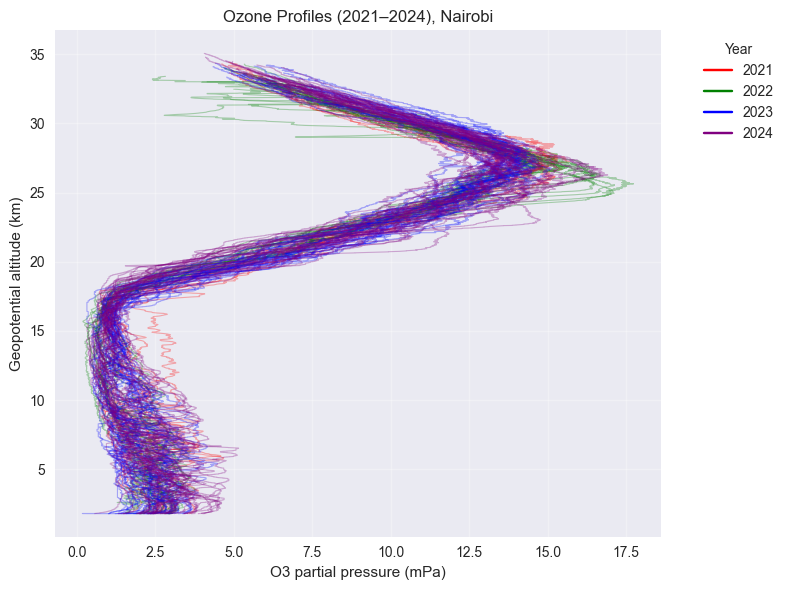

In [5]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Data Setup
base_dir = Path("Ozonesondes")
years    = range(2021, 2025)
exts     = {".txt", ".dat", ".tab"}

# Suppress warnings messages
import warnings
warnings.filterwarnings(
    "ignore",
    message="Glyph.*missing from font.*"
)

# Prepare figure
fig, ax = plt.subplots(figsize=(8, 6))

# Explicit color mapping by year
colors = {
    2021: "red",
    2022: "green",
    2023: "blue",
    2024: "purple"
}

# Loop over each file and plot its profile
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.is_dir():
        continue

    for fn in year_dir.iterdir():
        if fn.suffix.lower() not in exts:
            continue

        # locate header
        with fn.open() as f:
            for i, line in enumerate(f):
                if line.lstrip().startswith("Time") and "O3_mPa" in line:
                    header_idx  = i
                    header_line = line
                    break
            else:
                continue

        # Read geopotential altitude & ozone
        cols = header_line.strip().split()
        df   = pd.read_csv(
            fn,
            sep=r"\s+",
            engine="python",
            names=cols,
            skiprows=header_idx + 1,
            usecols=["GeopAlt","O3_mPa"],
            na_values=9000,
            comment="C"
        )

        # Drop invalids
        df["GeopAlt"] = pd.to_numeric(df["GeopAlt"], errors="coerce")
        df["O3_mPa"]  = pd.to_numeric(df["O3_mPa"], errors="coerce")
        df = df.dropna(subset=["GeopAlt","O3_mPa"])
        if df.empty:
            continue

        # Ozone Profile plot
        ax.plot(
            df["O3_mPa"],
            df["GeopAlt"],
            color=colors[yr],
            alpha=0.3,
            linewidth=0.8
        )

# Finalize plot
ax.set_xlabel("O3 partial pressure (mPa)")
ax.set_ylabel("Geopotential altitude (km)")
ax.set_title("Ozone Profiles (2021–2024), Nairobi")
ax.grid(alpha=0.3)

# Legend
for yr in years:
    ax.plot([], [], color=colors[yr], label=str(yr))
ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


OZONE MONTHLY AVERAGES FROM 2021 TO 2024

In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

base_dir = Path("Ozonesondes")
years    = range(2021, 2025)
exts     = {".txt", ".dat", ".tab"}

all_files = []
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.exists():
        print(f"⚠️ Missing folder: {year_dir}")
        continue

    # recursive find by extension
    files = []
    for ext in exts:
        files.extend(year_dir.rglob(f"*{ext}"))
    files = sorted(files)
    print(f"{yr}: found {len(files)} files ({len(files)/4:.1f} launches/month if uniform)")

    all_files.extend(files)

    # define altitude bin size
bin_width = 0.1  # km

cols = [
    "Time","Press","GeopAlt","Temp","RH","O3_mPa",
    "O3_ppmv","O3_DU","Wind_Dir","Wind_Spd","TPump",
    "O3CellI","GPS_Lat","GPS_Lon","GPS_Alt"
]

records = []

for fn in all_files:
    lines = fn.read_text().splitlines()

    # Extract launch date
    dt_line = next((L for L in lines if L.startswith("Launch Date")), None)
    if not dt_line:
        continue
    dt = pd.to_datetime(dt_line.split(":",1)[1].strip(),
                       format="%Y%m%d", errors="coerce")
    if pd.isna(dt):
        continue
    year, month = dt.year, dt.month

    # Find numeric block header
    try:
        hdr_i = next(i for i, L in enumerate(lines)
                     if L.strip().startswith("Time") and "O3_mPa" in L)
    except StopIteration:
        continue

    # Read profile
    df = pd.read_csv(
        fn,
        sep=r"\s+",
        engine="python",
        names=cols,
        header=None,
        skiprows=hdr_i + 2,
        na_values="9000"
    ).dropna(subset=["GeopAlt","O3_mPa"])
    if df.empty:
        continue

    # Bin the altitude
    df["GeopAlt_bin"] = (df["GeopAlt"] / bin_width).round() * bin_width

    # Keep only one value per alt-bin per flight
    df_bin = (
        df
        .groupby("GeopAlt_bin", as_index=False)
        .agg(O3_mPa=("O3_mPa","mean"))
    )

    # Tag and collect column headers
    df_bin["Year"]  = year
    df_bin["Month"] = month
    records.append(df_bin[["Year","Month","GeopAlt_bin","O3_mPa"]])

# Combine all launches
master = pd.concat(records, ignore_index=True)

monthly = (
    master
    .groupby(["Year","Month","GeopAlt_bin"], as_index=False)
    .agg(O3_mPa=("O3_mPa","mean"))
    .sort_values(["Year","Month","GeopAlt_bin"])
)

# Pivot for visual inspection
monthly["Year-Month"] = (
    monthly["Year"].astype(str)
    + "-"
    + monthly["Month"].astype(str).str.zfill(2)
)
pivot = monthly.pivot(
    index="GeopAlt_bin",
    columns="Year-Month",
    values="O3_mPa"
)

print(pivot.round(3).head(10))


# Tag flight by file-stem to count unique launches
tags = []
for fn in all_files:
    month_dt = pd.to_datetime(  # same logic as above
        next(L for L in fn.read_text().splitlines() if L.startswith("Launch Date"))
        .split(":",1)[1].strip(),
        format="%Y%m%d"
    )
    tags.append((month_dt.year, month_dt.month, fn.stem))

flight_counts = (
    pd.DataFrame(tags, columns=["Year","Month","Flight"])
      .drop_duplicates()
      .groupby(["Year","Month"])
      .size()
      .unstack(fill_value=0)
)
print(flight_counts)




2021: found 10 files (2.5 launches/month if uniform)
2022: found 17 files (4.2 launches/month if uniform)
2023: found 32 files (8.0 launches/month if uniform)
2024: found 36 files (9.0 launches/month if uniform)
Year-Month   2021-10  2021-11  2021-12  2022-01  2022-02  2022-03  2022-04  \
GeopAlt_bin                                                                  
1.8            2.896    2.632    2.074    2.844    2.165    2.567    2.541   
1.9            2.992    2.746    2.191    2.878    2.171    2.640    2.659   
2.0            3.076    2.819    2.294    2.947    2.218    2.728    2.773   
2.1            3.120    2.825    2.323    3.034    2.283    2.790    2.830   
2.2            3.132    2.821    2.338    3.074    2.344    2.827    2.853   
2.3            3.121    2.813    2.349    3.088    2.311    2.832    2.862   
2.4            3.071    2.812    2.367    3.065    2.303    2.795    2.839   
2.5            3.019    2.777    2.382    3.052    2.190    2.758    2.804   
2.6     

MONTHLY AVERAGE OZONE PROFILE PLOT FROM 2021 TO 2024

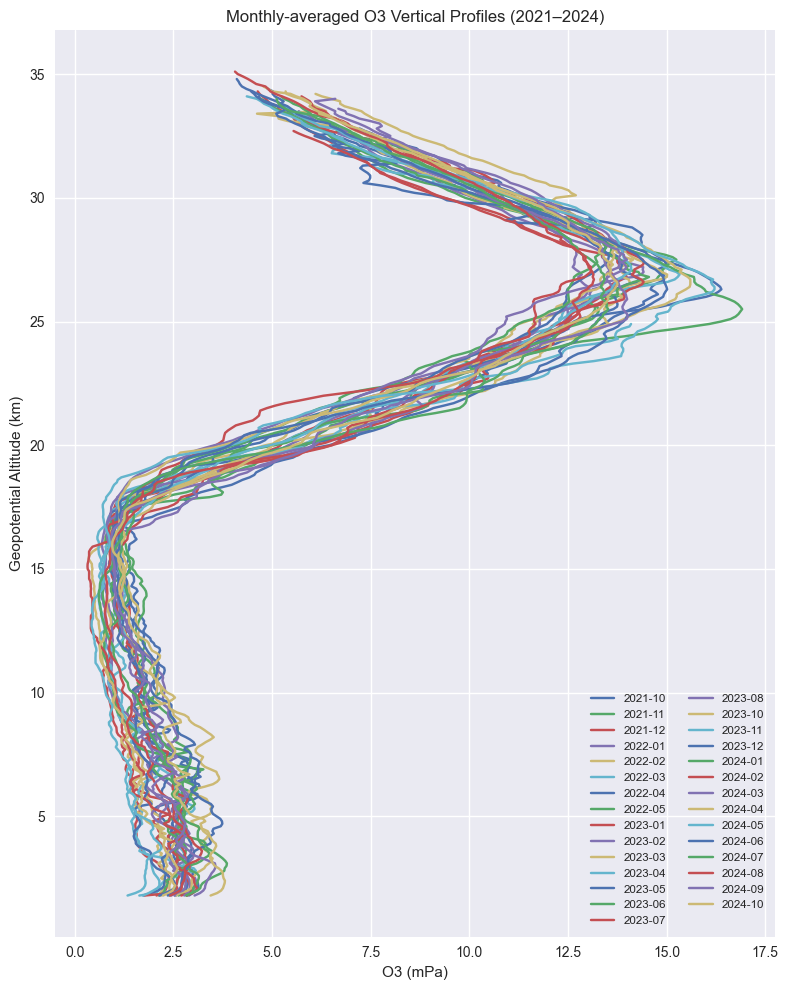

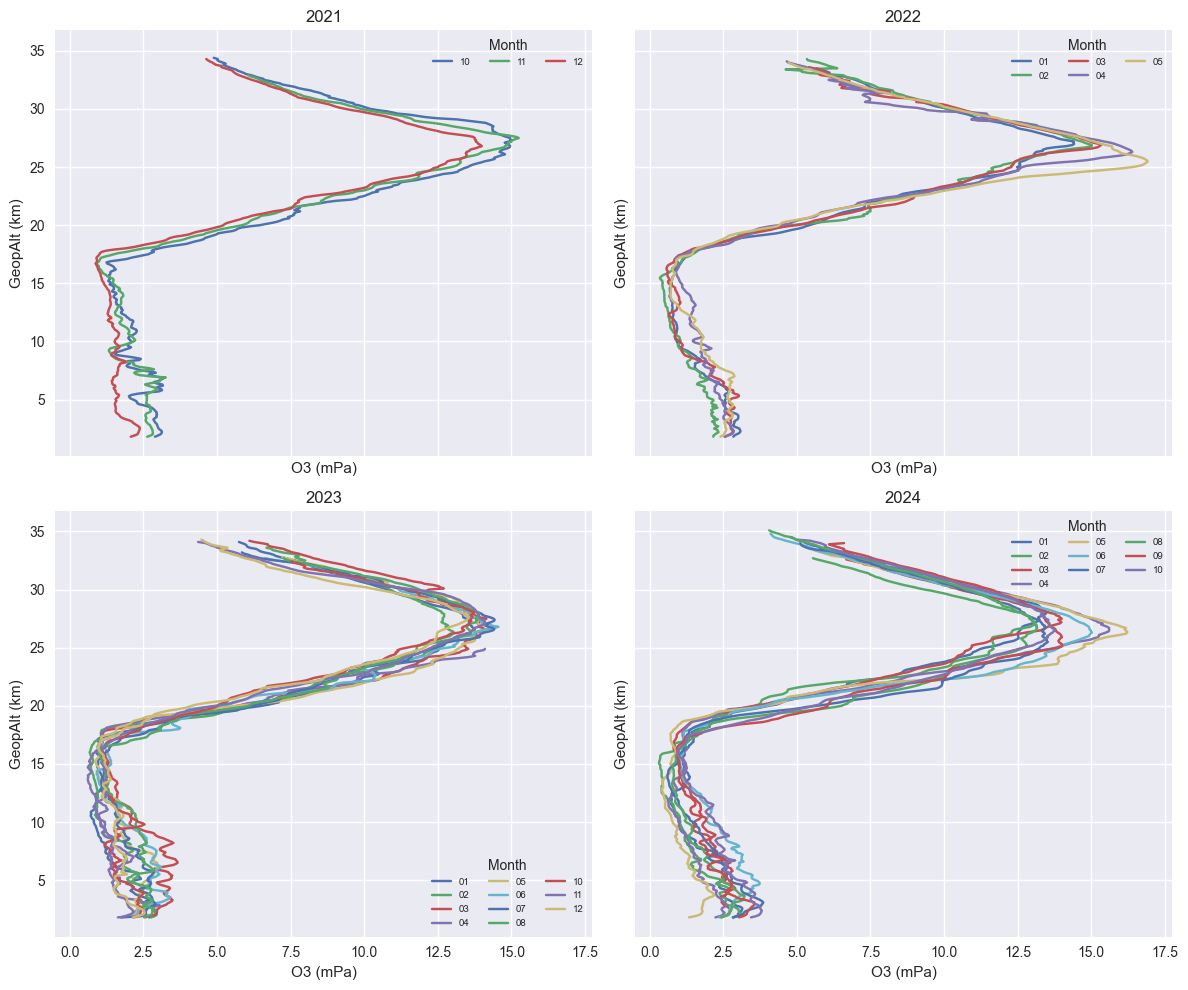

In [7]:
import matplotlib.pyplot as plt



plt.figure(figsize=(8, 10))

for col in pivot.columns:
    plt.plot(pivot[col], pivot.index, label=col)

# Altitude increases upward by default—do NOT invert y!

plt.xlabel("O3 (mPa)")
plt.ylabel("Geopotential Altitude (km)")
plt.title("Monthly-averaged O3 Vertical Profiles (2021–2024)")

plt.legend(loc="lower right", fontsize="small", ncol=2)

plt.tight_layout()
plt.show()


years = ["2021", "2022", "2023", "2024"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, yr in zip(axes, years):
    # select only the 12 months of this year
    cols = [c for c in pivot.columns if c.startswith(yr)]
    for c in cols:
        ax.plot(pivot[c], pivot.index, label=c.split("-")[1]) 
    ax.invert_yaxis()
    ax.set_title(yr)
    ax.set_xlabel("O3 (mPa)")
    ax.set_ylabel("GeopAlt (km)")
    ax.legend(title="Month", fontsize="x-small", ncol=3)

plt.tight_layout()
plt.show()


BREAKING DOWN THE O3 PROFILE INTO: TROPOSPHERE, TROPOPAUSE & STRATOSPHERE

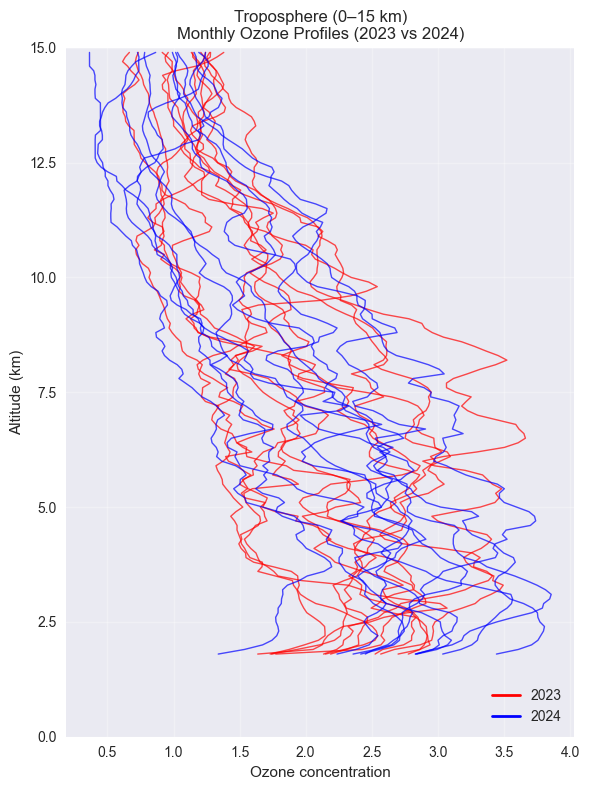

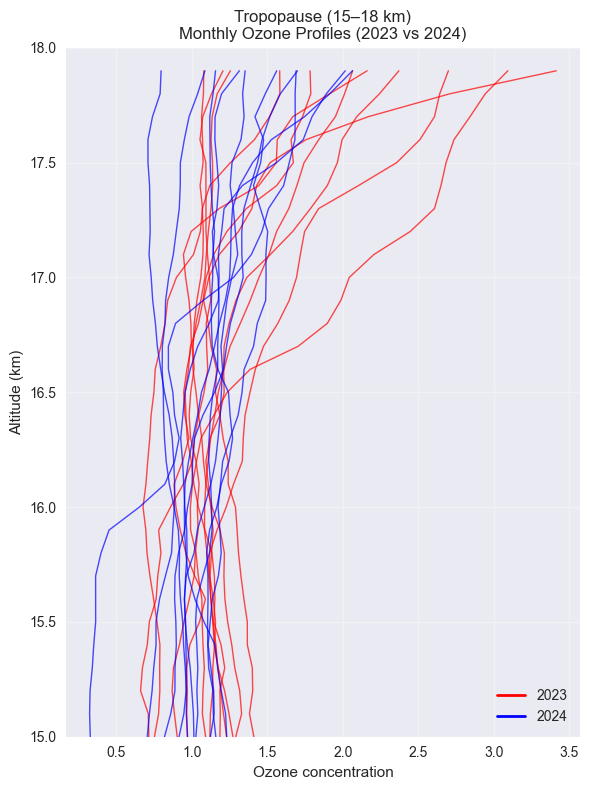

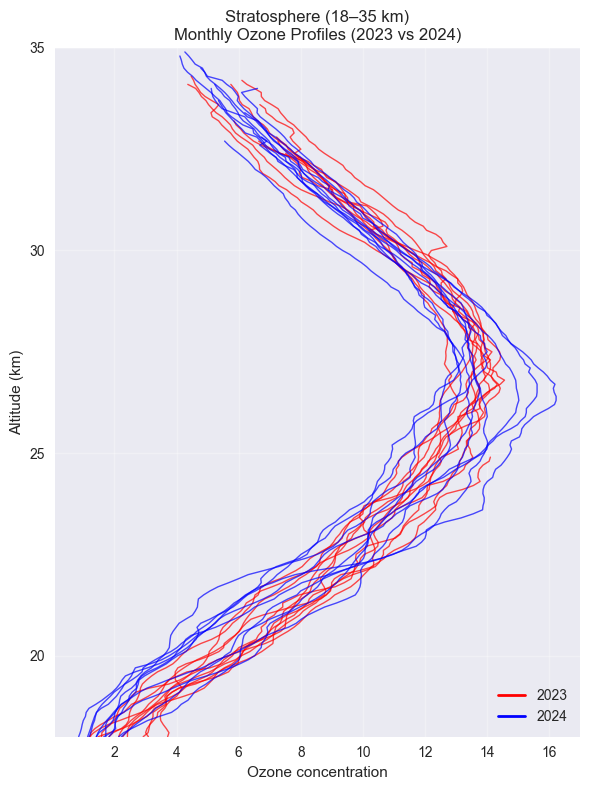

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Prepare & Filter the DataFrame

df = pivot.copy()
df.index = pd.to_numeric(df.index, errors='coerce')

# Pick only YYYY-MM columns
pattern    = r'^\d{4}-\d{2}$'
month_cols = [c for c in df.columns if re.match(pattern, str(c))]

# Subset, convert to datetime, sort
df_mon = df[month_cols].copy()
df_mon.columns = pd.to_datetime(df_mon.columns, format='%Y-%m')
df_mon = df_mon.reindex(sorted(df_mon.columns), axis=1)

# Keep only 2023 & 2024
df_mon = df_mon.loc[:, df_mon.columns.year.isin([2023, 2024])]

# Define altitude bands
bands = {
    'Troposphere (0–15 km)':    (0,  15),
    'Tropopause (15–18 km)':   (15, 18),
    'Stratosphere (18–35 km)': (18, 35),
}

# Plot monthly profiles with red/blue distinction
for name, (zmin, zmax) in bands.items():
    band_df = df_mon[(df_mon.index >= zmin) & (df_mon.index < zmax)]
    
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # proxy legend entries
    ax.plot([], [], color='red',  lw=2, label='2023')
    ax.plot([], [], color='blue', lw=2, label='2024')
    
    # actual monthly profiles
    for col in band_df.columns:
        color = 'red' if col.year == 2023 else 'blue'
        ax.plot(
            band_df[col],
            band_df.index,
            color=color,
            linewidth=1,
            alpha=0.7
        )
    
    # remove inversion and explicitly set y‐limits from low → high
    ax.set_ylim(zmin, zmax)
    
    ax.set_title(f'{name}\nMonthly Ozone Profiles (2023 vs 2024)')
    ax.set_xlabel('Ozone concentration')
    ax.set_ylabel('Altitude (km)')
    ax.grid(alpha=0.3)
    ax.legend(loc='lower right')
    ax.locator_params(axis='y', nbins=6)
    
    plt.tight_layout()
    plt.show()


NAIROBI SURFACE OZONE DATA EXTRACTION AND DATA FRAME

In [ ]:
from pathlib import Path
from datetime import datetime
import pandas as pd

data_dir = Path("SurfaceO3NRB")
files    = sorted(data_dir.glob("VRXZ07.*.*"))

# Preallocate lists
dates = []
o3s   = []

for fp in files:
    with fp.open() as f:
        # 1. Skip until the real header line
        for line in f:
            if line.startswith("Station/Location"):
                header   = line.strip().split(";")
                date_idx = header.index("Date")
                o3_idx   = header.index("dkl010z0")
                break

        # 2. Read and parse all subsequent data lines
        for line in f:
            parts = line.rstrip().split(";")
            if len(parts) <= max(date_idx, o3_idx):
                continue

            ds = parts[date_idx]
            os = parts[o3_idx]
            if ds == "-" or os == "-":
                continue

            # 3. Parse timestamp
            try:
                dt = datetime.strptime(ds, "%Y%m%d%H%M")
            except ValueError:
                continue

            # 4. Filter to 2024–2025
            if dt.year in (2024, 2025):
                dates.append(dt)
                o3s.append(float(os))

# Build one DataFrame and sort
all_o3 = pd.DataFrame({"DateTime": dates, "O3": o3s})
all_o3 = all_o3.sort_values("DateTime").reset_index(drop=True)

# Quick check
print(f"Extracted {len(all_o3)} records from {len(files)} files")
print(all_o3.head())



Extracted 279093 records from 30092 files
             DateTime    O3
0 2024-11-14 07:30:00  39.0
1 2024-11-14 07:50:00  59.0
2 2024-11-14 07:50:00  59.0
3 2024-11-14 07:50:00  59.0
4 2024-11-14 08:00:00  36.0


FROM THE DATA FRAME COMPUTE NAIROBI SURFACE O3 DAILY AVERAGES

In [ ]:
import pandas as pd

# Suppose all_o3 is your DataFrame with 279,093 rows and columns ['DateTime', 'O3']
df = all_o3.copy()

# Convert DateTime column or index to datetime
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime', 'O3'])
    df = df.set_index('DateTime')
else:
    # If DateTime is already the index
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.isna() & ~df['O3'].isna()]

# Resample to daily mean
O3NRB = df['O3'].resample('D').mean().to_frame('O3')

# Inspect
print(f"Computed daily averages for {len(O3NRB)} days")
print(f"Date range: {O3NRB.index.min().date()} → {O3NRB.index.max().date()}")
print(O3NRB.head())


Computed daily averages for 284 days
Date range: 2024-11-14 → 2025-08-24
                    O3
DateTime              
2024-11-14   86.728421
2024-11-15   59.065789
2024-11-16  106.673611
2024-11-17   67.583432
2024-11-18   69.423611


NAIROBI DAILY AVERAGE SURFACE O3 TIME SERIES

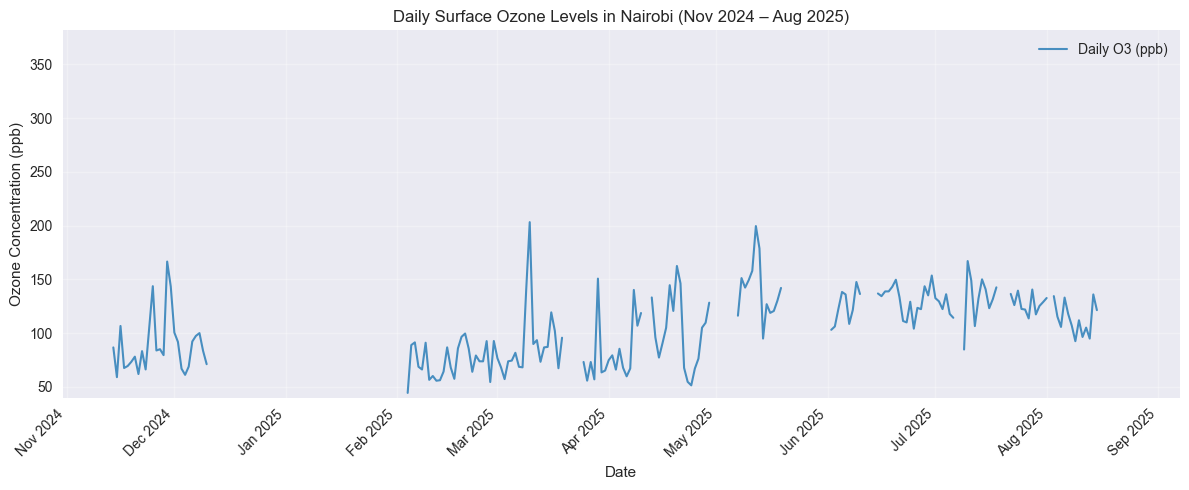

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure index is datetime and sorted 
O3NRB.index = pd.to_datetime(O3NRB.index)
O3NRB = O3NRB.sort_index()

# Create the figure and axis 
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the daily ozone values 
ax.plot(
    O3NRB.index,
    O3NRB["O3"],
    color="tab:blue",
    linewidth=1.5,
    alpha=0.8,
    label="Daily O3 (ppb)"
)

# Format x-axis with monthly ticks and labels 
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")

# Axis labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Ozone Concentration (ppb)")
ax.set_title("Daily Surface Ozone Levels in Nairobi (Nov 2024 – Aug 2025)")

# Set y-limits based on data range 
ymin, ymax = O3NRB["O3"].min(), O3NRB["O3"].max()
ax.set_ylim(ymin * 0.9, ymax * 1.1)

# Add grid and legend
ax.grid(alpha=0.3)
ax.legend()

# Layout adjustment and display
plt.tight_layout()
plt.show()


MT KENYA SURFACE O3 DATA EXTRACTION AND DATA FRAME

In [ ]:
import pandas as pd
from pathlib import Path

# Point to your data folder
data_dir = Path("SurfaceO3MKN")

# Grab all files in there
files = sorted(data_dir.glob("*"))

# Container for per-file DataFrames
frames = []

for f in files:
    try:
        # Read space-delimited file, keep only date, time and ozone
        df = pd.read_csv(
            f,
            sep=r"\s+",           
            comment="#",
            usecols=["pcdate", "pctime", "o3"],
            dtype={"pcdate": str, "pctime": str, "o3": str},
        )
    except Exception as e:
        print(f"  → skipped {f.name}: {e}")
        continue

    # Combine pcdate + pctime into a single datetime column
    df["datetime"] = pd.to_datetime(
        df["pcdate"] + " " + df["pctime"],
        format="%Y-%m-%d %H:%M:%S",
        errors="coerce",
    )

    # Drop rows where datetime parse failed
    df = df.dropna(subset=["datetime"])

    # Convert ozone from scientific notation string to float
    df["o3"] = pd.to_numeric(df["o3"], errors="coerce")

    # Keep only what we need
    frames.append(df[["datetime", "o3"]])

# Concatenate everything into one time-series DataFrame
O3_MtKenya = pd.concat(frames, ignore_index=True)

# Sort by time and reset index
O3_MtKenya = O3_MtKenya.sort_values("datetime").reset_index(drop=True)

# Quick check
print(O3_MtKenya.head())
print(O3_MtKenya.info())


  → skipped tei49c: [Errno 13] Permission denied: 'SurfaceO3MKN\\tei49c'
             datetime     o3
0 2024-11-14 09:10:00  30.20
1 2024-11-14 09:11:00  29.57
2 2024-11-14 09:12:00  28.99
3 2024-11-14 09:13:00  28.47
4 2024-11-14 09:14:00  28.79
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298715 entries, 0 to 298714
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  298715 non-null  datetime64[ns]
 1   o3        292934 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 MB
None


AVERAGING THE MT. KENYA SURFACE O3 DATA INTO DAILY RESOLUTION

In [ ]:
import pandas as pd

# Drop missing O₃ values
df = O3_MtKenya.dropna(subset=["o3"]).copy()

# Extract date (no time)
df["date"] = df["datetime"].dt.date

# Group by date and compute mean
daily_avg = (
    df.groupby("date")["o3"]
    .mean()
    .reset_index(name="daily_avg_o3")
)

print(daily_avg.head())
print(f"Computed {len(daily_avg)} daily averages from {daily_avg['date'].min()} to {daily_avg['date'].max()}.")


         date  daily_avg_o3
0  2024-11-14     28.757720
1  2024-11-15     28.004517
2  2024-11-16     28.635607
3  2024-11-17     37.149815
4  2024-11-18     42.797151
Computed 200 daily averages from 2024-11-14 to 2025-09-04.


PLOTTING MT. KENYA SURFACE O3 DIURNAL CYCLE AND SEASONAL VARIATION

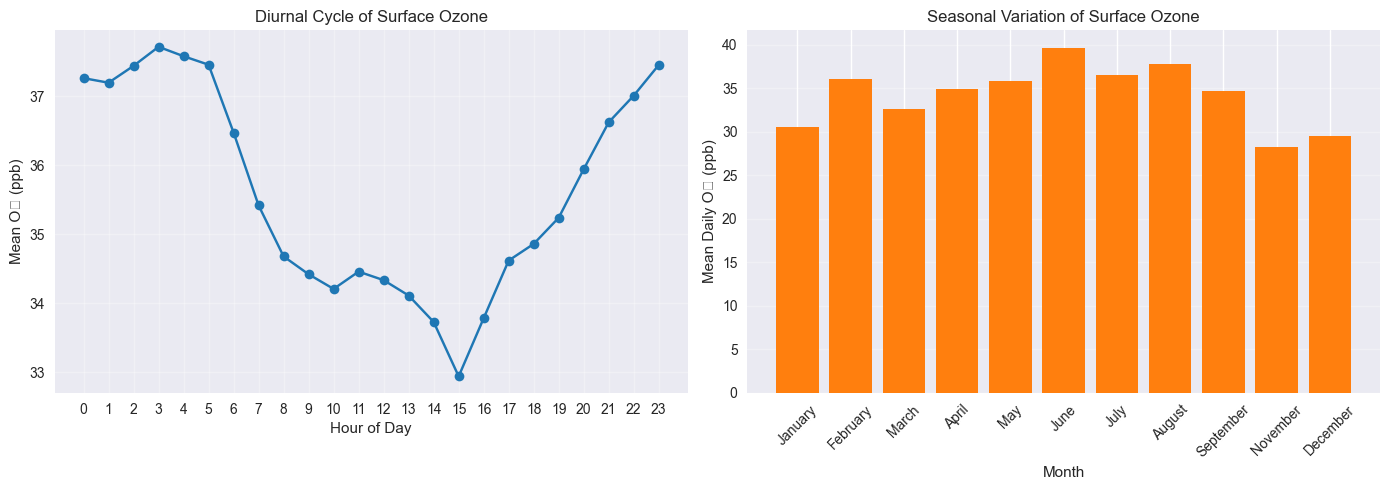

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare diurnal cycle from minute‐resolution data
df_min = O3_MtKenya.dropna(subset=["o3"]).copy()
df_min["hour"] = df_min["datetime"].dt.hour
hourly_mean = df_min.groupby("hour")["o3"].mean()

# Prepare seasonal variation from daily averages
daily_avg["date"] = pd.to_datetime(daily_avg["date"])
daily_avg["month"] = daily_avg["date"].dt.month_name()
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
monthly_mean = (
    daily_avg.groupby("month")["daily_avg_o3"]
    .mean()
    .reindex(month_order)
    .dropna()
)

# Plot both panels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Diurnal cycle
axes[0].plot(hourly_mean.index, hourly_mean.values, color="tab:blue", marker="o")
axes[0].set_title("Diurnal Cycle of Surface Ozone")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Mean O₃ (ppb)")
axes[0].set_xticks(range(0, 24))
axes[0].grid(alpha=0.3)

# Seasonal variation
axes[1].bar(monthly_mean.index, monthly_mean.values, color="tab:orange")
axes[1].set_title("Seasonal Variation of Surface Ozone")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Mean Daily O₃ (ppb)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


DAILY AVERAGE SURFACE O3 TIME SERIES PLOT FOR MT. KENYA

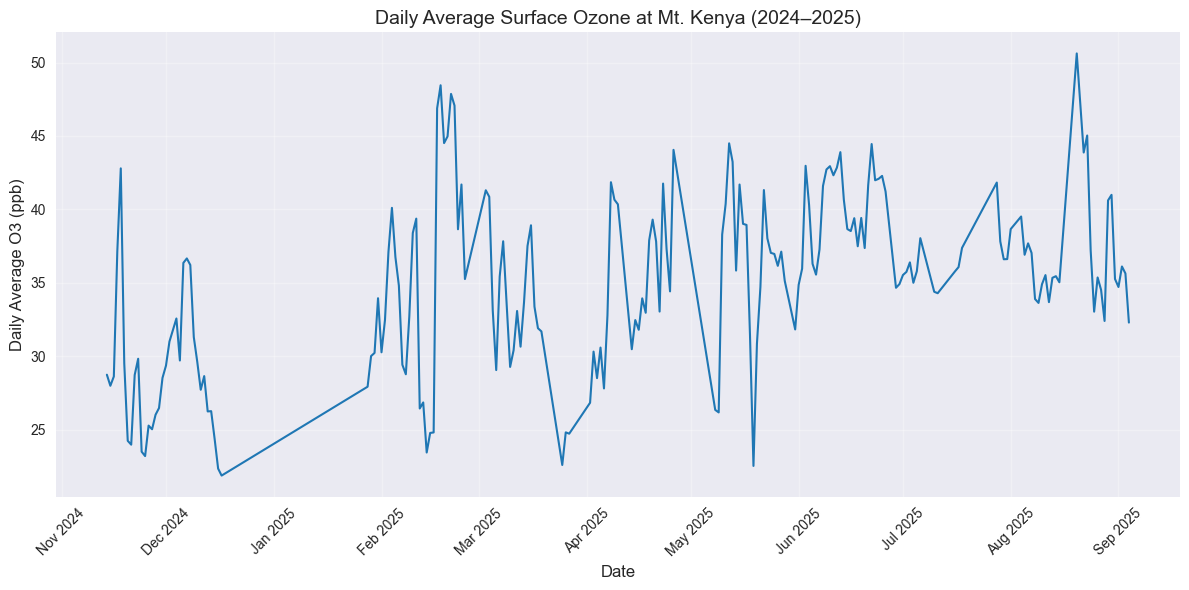

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Drop missing values
df = daily_avg.dropna(subset=["daily_avg_o3"]).copy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["daily_avg_o3"], color="tab:blue", linewidth=1.5)

# Format x‐axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

# Labels & title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Average O3 (ppb)", fontsize=12)
plt.title("Daily Average Surface Ozone at Mt. Kenya (2024–2025)", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


SURFACE O3 DATA HISTORY FROM 2024 TO 2025 FOR MT. KENYA STATION

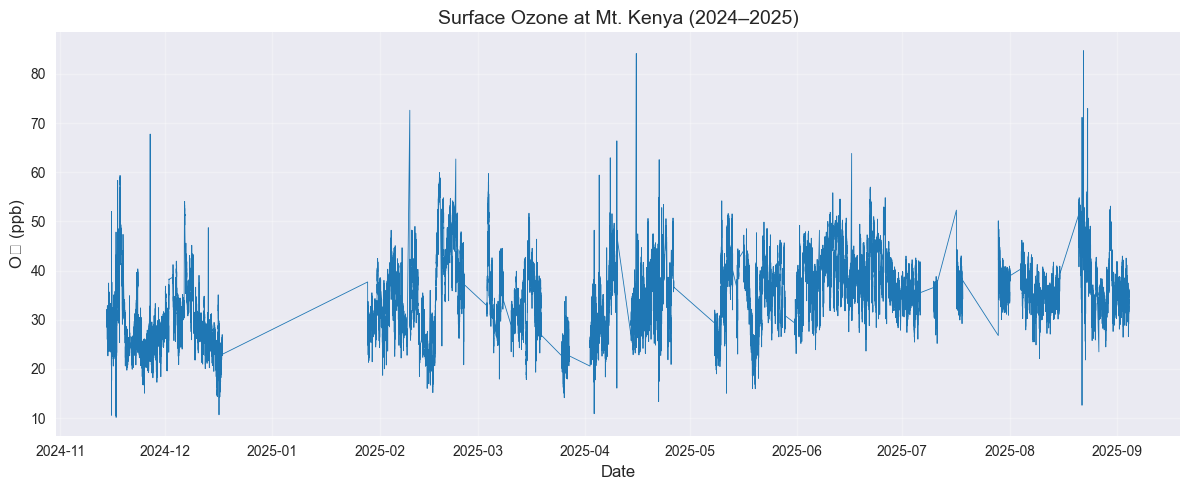

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load & clean missing data
df = O3_MtKenya.dropna(subset=["o3"]).copy()

# Discard readings below 10 ppb
df = df[df["o3"] >= 10]

# Plot remaining series
plt.figure(figsize=(12, 5))
plt.plot(df["datetime"], df["o3"],
         color="tab:blue", linewidth=0.6)
plt.title("Surface Ozone at Mt. Kenya (2024–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("O₃ (ppb)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TCO TIME SERIES PLOT FOR NRB STATION 2023 TO 2025 (BREWER)

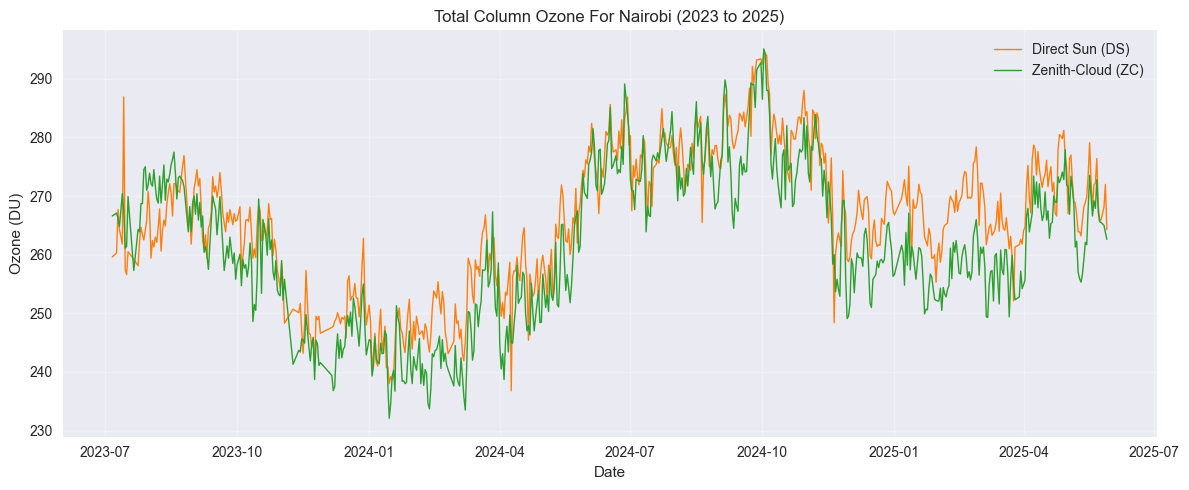

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#Load the CSV
data_dir = Path("TCOBREWER")
file     = data_dir / "tcobrewer.csv"
df       = pd.read_csv(file)

# Build date & convert to numeric
df["date"] = pd.to_datetime(df[["YEAR", "MONTH", "DAY"]])
df["DS"]   = pd.to_numeric(df["DS"], errors="coerce")
df["ZC"]   = pd.to_numeric(df["ZC"], errors="coerce")

# Sort by date, drop rows where both are missing
df = df.sort_values("date").dropna(subset=["DS", "ZC"], how="all")

# Eliminate out-of-range values (below 230 or above 300 DU)
mask_ds = df["DS"].between(230, 300)
mask_zc = df["ZC"].between(230, 300)
df      = df[mask_ds & mask_zc]

# Plot filtered time series
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["DS"],
         color="tab:orange", linewidth=1, label="Direct Sun (DS)")
plt.plot(df["date"], df["ZC"],
         color="tab:green", linewidth=1, label="Zenith-Cloud (ZC)")

plt.title("Total Column Ozone For Nairobi (2023 to 2025)")
plt.xlabel("Date")
plt.ylabel("Ozone (DU)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TCO DATA HISTORY FOR NAIROBI (DOBSON)

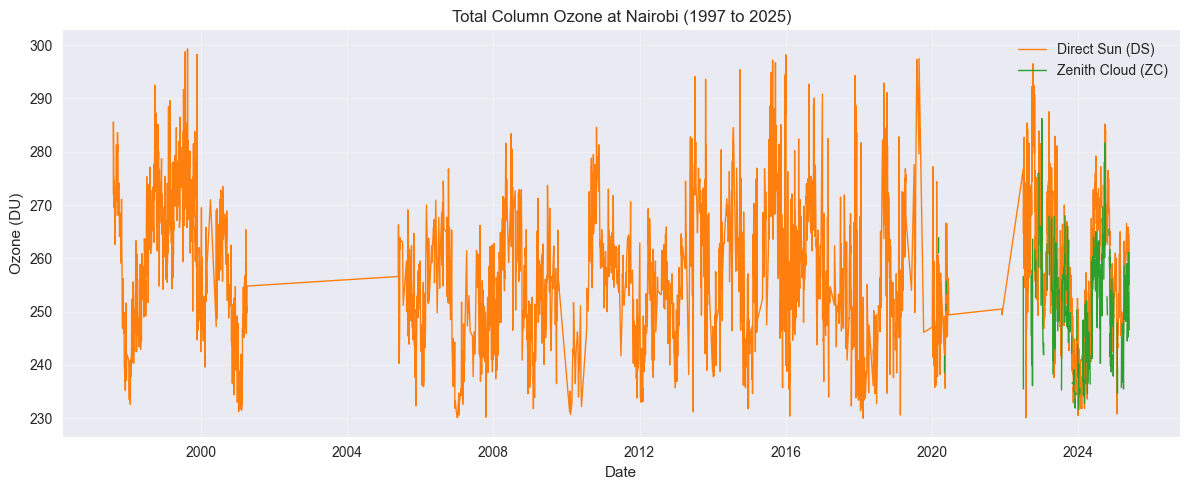

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
file = Path("TCODOBSON") / "tcodobson.csv"
df   = pd.read_csv(file)

# Parse date & convert to numeric
df["date"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y", errors="coerce")
df["DS"]   = pd.to_numeric(df["DS"], errors="coerce")
df["ZC"]   = pd.to_numeric(df["ZC"], errors="coerce")

# Limit to 1997–2025
df = df[(df["date"] >= "1997-01-01") & (df["date"] <= "2025-12-31")]

# Remove values outside 230–300 DU
df["DS"] = df["DS"].where(df["DS"].between(230, 300))
df["ZC"] = df["ZC"].where(df["ZC"].between(230, 300))

# Drop rows where both become NaN
df = df.dropna(subset=["DS", "ZC"], how="all").sort_values("date")

# Plot filtered time series
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["DS"],
         label="Direct Sun (DS)",   color="tab:orange",  linewidth=1)
plt.plot(df["date"], df["ZC"],
         label="Zenith Cloud (ZC)", color="tab:green", linewidth=1)

plt.title("Total Column Ozone at Nairobi (1997 to 2025)")
plt.xlabel("Date")
plt.ylabel("Ozone (DU)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TCO TIME SERIES FOR NRB STATION 2023 TO 2025 (DOBSON)

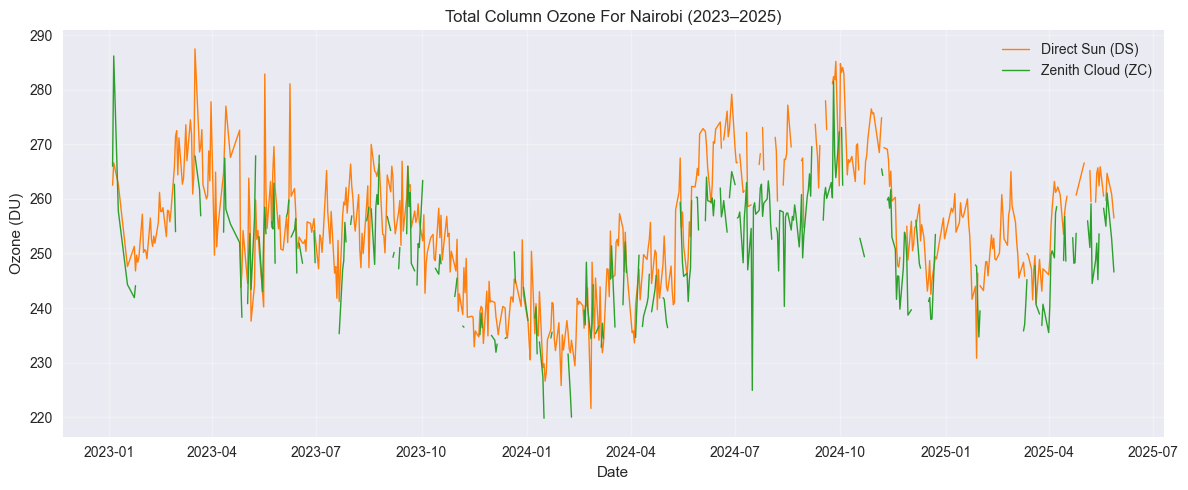

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
file = Path("TCODOBSON") / "tcodobson.csv"
df   = pd.read_csv(file)

# Parse date & convert
df["date"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y", errors="coerce")
df["DS"]   = pd.to_numeric(df["DS"], errors="coerce")
df["ZC"]   = pd.to_numeric(df["ZC"], errors="coerce")

# Keep only 1997–2025
start, end = "2023-01-01", "2025-12-31"
df = df[(df["date"] >= start) & (df["date"] <= end)].sort_values("date")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df.date, df.DS, label="Direct Sun (DS)",   color="tab:orange",  lw=1)
plt.plot(df.date, df.ZC, label="Zenith Cloud (ZC)", color="tab:green", lw=1)

plt.title("Total Column Ozone For Nairobi (2023–2025)")
plt.xlabel("Date")
plt.ylabel("Ozone (DU)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
import glob
import pandas as pd

# Find all your data files
files = glob.glob("SurfaceO3NRB/VRXZ07.*")

# Read and clean them
frames = []
for f in files:
    df = pd.read_csv(
        f,
        sep=";",
        skiprows=2,
        header=0,
        usecols=["Date", "dkl010z0"],
        na_values="-",
        dtype={"dkl010z0": "float32"},
    )
    df.dropna(subset=["dkl010z0"], inplace=True)
    frames.append(df)

# Concatenate
nairobio3 = pd.concat(frames, ignore_index=True)

# Parse dates and rename
nairobio3["Date"] = pd.to_datetime(nairobio3["Date"], format="%Y%m%d%H%M")
nairobio3.rename(columns={"dkl010z0": "ozone_ppb"}, inplace=True)

# Sort and inspect
nairobio3.sort_values("Date", inplace=True, ignore_index=True)

print(nairobio3.head())
print("Total rows:", nairobio3.shape[0])


                 Date  ozone_ppb
0 2024-11-14 07:30:00       39.0
1 2024-11-14 07:50:00       59.0
2 2024-11-14 07:50:00       59.0
3 2024-11-14 07:50:00       59.0
4 2024-11-14 08:00:00       36.0
Total rows: 279093


In [21]:
import pandas as pd

# ensure Date is a datetime
nairobio3['Date'] = pd.to_datetime(nairobio3['Date'])

# set Date as index and resample by calendar day
daily_avg = (
    nairobio3
    .set_index('Date')
    .resample('D')['ozone_ppb']
    .mean()
    .reset_index()
)

# rename for clarity
daily_avg.columns = ['Date', 'o3_daily_avg_ppb']

print(daily_avg.head())
print(f"Total days: {len(daily_avg)}")


        Date  o3_daily_avg_ppb
0 2024-11-14         86.728424
1 2024-11-15         59.065788
2 2024-11-16        106.673615
3 2024-11-17         67.583435
4 2024-11-18         69.423615
Total days: 284


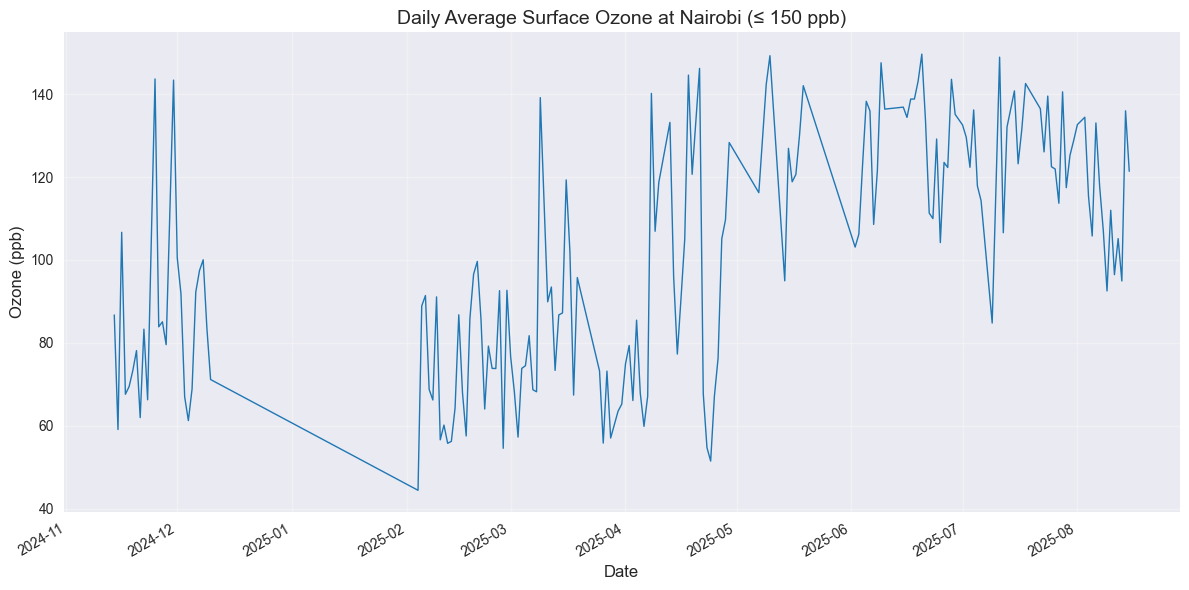

In [22]:
import matplotlib.pyplot as plt

# keep only rows where o3_daily_avg_ppb ≤ 150
filtered = daily_avg[daily_avg['o3_daily_avg_ppb'] <= 150]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(filtered['Date'], filtered['o3_daily_avg_ppb'],
        color='tab:blue', linewidth=1)

ax.set_title('Daily Average Surface Ozone at Nairobi (≤ 150 ppb)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ozone (ppb)', fontsize=12)
ax.grid(True, alpha=0.3)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


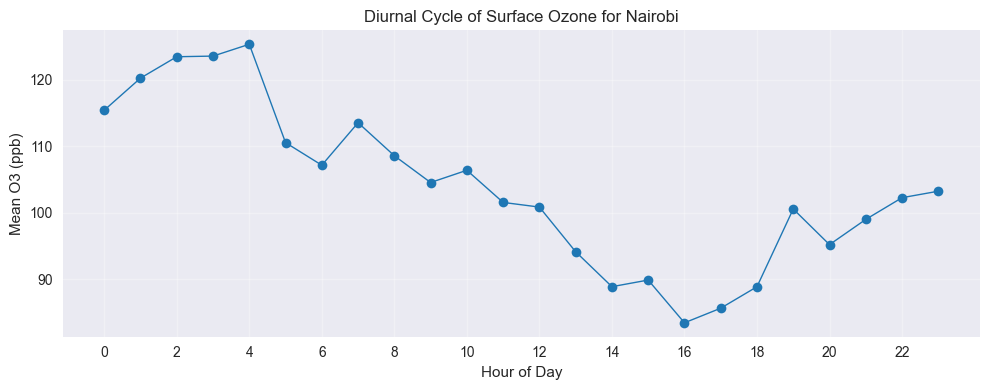

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# ensure Date is datetime
nairobio3['Date'] = pd.to_datetime(nairobio3['Date'])

# extract hour and compute mean ozone for each hour
nairobio3['Hour'] = nairobio3['Date'].dt.hour
diurnal = (
    nairobio3
    .groupby('Hour')['ozone_ppb']
    .mean()
    .reindex(range(24))
)

# Plot the diurnal cycle
plt.figure(figsize=(10, 4))
plt.plot(diurnal.index, diurnal.values,
         marker='o', color='tab:blue', linewidth=1)

plt.xlabel('Hour of Day')
plt.ylabel('Mean O3 (ppb)')
plt.title('Diurnal Cycle of Surface Ozone for Nairobi')
plt.xticks(range(0, 24, 2))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
